In [16]:
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
# data = np.loadtxt('../data/original_data.csv', delimiter=' ')
df = pd.read_csv('../data/original_data.csv',sep=' ', names=['issuercountry', 'txvariantcode', 'issuer_id', 'amount', 'currencycode', 'shoppercountry', 'interaction', 'verification', 'cvcresponse', 'creationdate_stamp', 'accountcode', 'mail_id', 'ip_id', 'card_id', 'label'])
df.head()

,issuercountry,txvariantcode,issuer_id,amount,currencycode,shoppercountry,interaction,verification,cvcresponse,creationdate_stamp,accountcode,mail_id,ip_id,card_id,label
0,18,10,465859.0,4370.0,3,26,1,2,1,1.444259e+09,0,32318,45370,1,1
1,68,4,438088.0,13850.0,2,134,1,1,0,1.438945e+09,1,1567,33933,2,1
2,18,12,552213.0,6595.0,3,26,1,1,1,1.437862e+09,0,64936,255836,3,1
3,18,10,492181.0,2895.0,3,26,1,1,1,1.443373e+09,0,95340,242162,4,1
4,55,9,493136.0,223900.0,0,69,1,1,0,1.442081e+09,3,250940,70404,5,1


## One-hot encoding

In [3]:
df = pd.get_dummies(df, columns=[
    'issuercountry',
    'txvariantcode',
    'currencycode',
    'shoppercountry',
    'verification',
    'cvcresponse',
    'accountcode'])

## Split data and label

In [14]:
X = np.asmatrix(df.drop(['label'], axis=1))
y = df['label']
print(X.shape)
print(y.shape)

(236698, 297)
(236698,)


## Normalization

In [62]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)

## PCA

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=.9999999)
X_pca = pca.fit_transform(X)
print(X_pca.shape)
print(pca.explained_variance_ratio_)

(236698, 1)
[1.]


(0.0, 600.0)

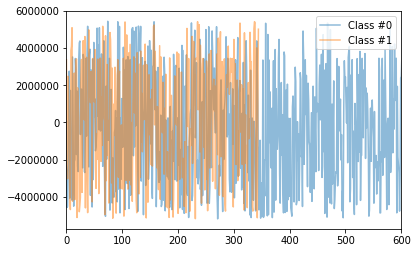

In [27]:
plt.plot(X_pca[y == 0], label="Class #0",
                 alpha=0.5)
plt.plot(X_pca[y == 1], label="Class #1",
                 alpha=0.5)
plt.legend()
plt.xlim([0.0, 600.0])

## Classification

In [76]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                 ratio='auto',
                                 replacement=False,
                                 random_state=0)

y_pred = cross_val_predict(bbc,X,y,cv=10)
confusion_matrix(y,y_pred)

array([[234125,   2228],
       [     0,    345]])

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# initialize simple classification metrics
TP = 0
FP = 0
FN = 0
TN = 0
F1 = 0
j = 0

# prepare for 10-fold stratified cross-validation
cv = StratifiedKFold(n_splits=10)

# split each fold into a training and test set
for train, test in cv.split(X,y):
    j += 1

    # create and train bagging decision tree classifier
    bbc.fit(X[train],y[train])
    # predict classifier labels
    Y_labels = bbc.predict(X[test])

    # compute and output simple metrics
    for i in range(len(Y_labels)):
        if y[test][i] == 1 and Y_labels[i] == 1:
            TP += 1
        if y[test][i] == 0 and Y_labels[i] == 1:
            FP += 1
        if y[test][i] == 1 and Y_labels[i] == 0:
            FN += 1
        if y[test][i] == 0 and Y_labels[i] == 0:
            TN += 1
    F1 += f1_score(y[test],Y_labels)
    print('Iteration: ' + str(j))
    print('TP: ' + str(TP))
    print('FP: ' + str(FP))
    print('FN: ' + str(FN))
    print('TN: ' + str(TN))
    print('F1: ' + str(F1/j))